# Выбор локации для скважины при помощи машинного обучения

Добывающая компания «ГлавРосГосНефть» поставила исследовательскую задачу: нужно решить, где бурить новую скважину для добычи нефти.

Выбор локации в компании осуществляется по следующей методике:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


**Цель проекта** — определить оптимальное место для бурения новой нефтяной скважины на основе анализа данных геологоразведки трёх регионов. 

Для достижения цели проекта необходимо: 
- Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
- Проанализировать возможную прибыль и риски техникой *Bootstrap.*


**Описание данных**

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерено качество нефти и объём её запасов. 

Данные геологоразведки трёх регионов содержат следующие сведения:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

На пути к достижению цели исследования нужно решить следующие **задачи**:
1. Проанализировать данные о характеристиках скважин в каждом из регионов.
2. Построить модель для прогнозирования объёма запасов нефти в новых скважинах на основе имеющихся данных.
3. Выбрать наиболее перспективные скважины для бурения.
4. Определить регион, в котором бурение новых скважин будет наиболее экономически выгодным.

**Условия для решения задач**:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Ожидаемые результаты проекта**:
1. Построена модель для прогнозирования объёма запасов нефти в новых скважинах.
2. Выбраны наиболее перспективные скважины для бурения.
3. Определён регион, в котором бурение новых скважин будет наиболее экономически выгодным.

В результате проекта компания «ГлавРосГосНефть» получит информацию о том, где лучше всего пробурить новую скважину. На основе этой информации компания сможет принять обоснованное решение о месте и времени бурения, что позволит ей максимизировать прибыль и минимизировать риски.

In [40]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# импортируем класс для расчета коэффициентов корреляции Спирмена
from scipy.stats import spearmanr

# импортируем класс для формирования выборок
from sklearn.model_selection import train_test_split

# импортируем класс для обучения модели линейной регрессии
from sklearn.linear_model import LinearRegression

# импортируем класс для масштабирования данных
from sklearn.preprocessing import StandardScaler

# импортируем функцию для расчета среднеквадратической ошибки 
from sklearn.metrics import mean_squared_error

# установим размер валидационной выборки
TEST_SIZE=0.25

# установим значение переменной RANDOM_STATE
RANDOM_STATE=42

# установим палетку для графиков
sns.set_palette('Set2')

## Загрузка и подготовка данных

В рамках данного раздела будут осуществлены следующие шаги:
* **Загрузка данных**. Загрузку будем производить из предоставленных данных;
* **Предобработка данных**. Этап предобработки будет направлен на то, чтобы выявить дубликаты и пропуски в наборе данных для каждого региона;
* **Исследовательский анализ данных** Исследовательский анализ данных проводится с целью описания закономерностей распределения признаков;
* **Корреляционный анализ признаков**. Корреляционный анализ признаков служит для того, чтобы количественно оценить тенденции взаимосвязей признаков друг с другом.


В наших данных содержатся три признака точек, но в условии к заданию сказано, что нам должно быть неважно, что они означают. Вместе с этим есть указание на то, что сами признаки значимы. 

Тем не менее, для того, чтобы сделать надежные и достоверные выводы по результатам исследования, мы должны провести перечисленные этапы разведочного анализ данных.

### Загрузка данных

In [41]:
# читаем файлы csv с данными для трех регионов
region_1 = pd.read_csv('/datasets/geo_data_0.csv')
region_2 = pd.read_csv('/datasets/geo_data_1.csv')
region_3 = pd.read_csv('/datasets/geo_data_2.csv')

Посмотрим на загруженные данные.

Поскольку данные в наборах однотипные, будем использовать цикл для того, чтобы отображать информацию о датасетах одновременно по трем регионам.

In [42]:
# создадим список датафреймов
dfs = [region_1, region_2, region_3]

In [43]:
# выведем информацию о данных сразу по трем регионам при помощи цикла
for i, df in enumerate(dfs):
    print(f'Информация о наборе данных по региону {i+1}')
    print(df.info())
    print('\n')

Информация о наборе данных по региону 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Информация о наборе данных по региону 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Информация о наборе данных по региону 

In [44]:
# выведем первые пять строк датасета сразу по трем регионам при помощи цикла
for i, df in enumerate(dfs):
    print(f'Первые пять строк набора данных по региону {i+1}')
    print(df.head().round(2))
    print('\n')

Первые пять строк набора данных по региону 1
      id    f0    f1    f2  product
0  txEyH  0.71 -0.50  1.22   105.28
1  2acmU  1.33 -0.34  4.37    73.04
2  409Wp  1.02  0.15  1.42    85.27
3  iJLyR -0.03  0.14  2.98   168.62
4  Xdl7t  1.99  0.16  4.75   154.04


Первые пять строк набора данных по региону 2
      id     f0     f1    f2  product
0  kBEdx -15.00  -8.28 -0.01     3.18
1  62mP7  14.27  -3.48  1.00    26.95
2  vyE1P   6.26  -5.95  5.00   134.77
3  KcrkZ -13.08 -11.51  5.00   137.95
4  AHL4O  12.70  -8.15  5.00   134.77


Первые пять строк набора данных по региону 3
      id    f0    f1    f2  product
0  fwXo0 -1.15  0.96 -0.83    27.76
1  WJtFt  0.26  0.27 -2.53    56.07
2  ovLUW  0.19  0.29 -5.59    62.87
3  q6cA6  2.24 -0.55  0.93   114.57
4  WPMUX -0.52  1.72  5.90   149.60




В переменных представлены наборы данных, в которых содержатся вещественные значения количественных признаков (`f0`, `f1`, `f2` и `product`) и поле для идентификатора скважины в текстовом формате (`id`). 

Данные загружены. 
Проверим имеются ли в данных дубликаты и пропуски.

### Предобработка данных

В этом подразделе убедимся в отсутствии дубликатов и пропусков в наборе данных для каждого региона. 

In [45]:
# выводим количество дублирующихся строк в наборе данных 
for i, df in enumerate(dfs):
    print(f'Количество дублирующихся строк в наборе данных по региону {i+1} = {df.duplicated().sum()}')

Количество дублирующихся строк в наборе данных по региону 1 = 0
Количество дублирующихся строк в наборе данных по региону 2 = 0
Количество дублирующихся строк в наборе данных по региону 3 = 0


In [46]:
# подсчитываем количество пропущенных значений (NaN) в каждом столбце набора данных
for i, df in enumerate(dfs):
    print(f'Количество пропущенных значений в столбцах набора данных по региону {i+1}')
    print(df.isna().sum())
    print('\n')

Количество пропущенных значений в столбцах набора данных по региону 1
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Количество пропущенных значений в столбцах набора данных по региону 2
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Количество пропущенных значений в столбцах набора данных по региону 3
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64




Дубликатов и пропусков в датасетах нет. 

В рамках этого подраздела напоследок установим идентификаторы скважин в качестве индексов датафреймов.

In [47]:
# установим id в качестве индекса
region_1 = region_1.set_index('id')
region_2 = region_2.set_index('id')
region_3 = region_3.set_index('id')

# создадим список датафреймов
dfs = [region_1, region_2, region_3]

Перейдем к исследовательскому анализу данных.

### Исследовательский анализ данных

Исследовательский анализ будет проведен в следующем формате: 
* Анализ описательных статистик - построение таблицы с описательной статистикой для каждого региона;
* Анализ распределения целевого признака (объема запасов нефти в скважине) - построение гистограмм распределения и диаграмм размаха;
* Анализ совместного распределения признаков (построение парных диаграмм рассеяния для все признаков, включая целевой).

Выведем на экран таблицы с описательной статистикой для каждого набора данных.

In [48]:
# выведем таблицы с описательной статистикой для каждого датасета при помощи цикла 
# запустим цикл по всем элементам списка dfs, для каждого набора данных - напечатаем таблицу, i+1 - это номер региона
for i, df in enumerate(dfs):
    print(f'Описательная статистика признаков региона {i+1}')
    print(df.describe().round(2).T)
    print('\n')

Описательная статистика признаков региона 1
            count   mean    std    min    25%    50%     75%     max
f0       100000.0   0.50   0.87  -1.41  -0.07   0.50    1.07    2.36
f1       100000.0   0.25   0.50  -0.85  -0.20   0.25    0.70    1.34
f2       100000.0   2.50   3.25 -12.09   0.29   2.52    4.72   16.00
product  100000.0  92.50  44.29   0.00  56.50  91.85  128.56  185.36


Описательная статистика признаков региона 2
            count   mean    std    min    25%    50%     75%     max
f0       100000.0   1.14   8.97 -31.61  -6.30   1.15    8.62   29.42
f1       100000.0  -4.80   5.12 -26.36  -8.27  -4.81   -1.33   18.73
f2       100000.0   2.49   1.70  -0.02   1.00   2.01    4.00    5.02
product  100000.0  68.83  45.94   0.00  26.95  57.09  107.81  137.95


Описательная статистика признаков региона 3
            count  mean    std    min    25%    50%     75%     max
f0       100000.0   0.0   1.73  -8.76  -1.16   0.01    1.16    7.24
f1       100000.0  -0.0   1.73  -7.08 

На основе этих данных можно сделать следующие выводы:

**Регион 1.** 
* В регионе 1 среднее значение объёма запасов нефти (`product`) составляет 92,5 тыс. баррелей. Стандартное отклонение объёма запасов составляет 44,29 тыс. баррелей, это значит, что значения объёма запасов варьируются в широком диапазоне. Максимальное значение объёма запасов равно 185,36 тыс. баррелей. 
* Признак `f0` имеет среднее значение около 0,5 и стандартное отклонение около 0,87. Это говорит о том, что значения признака f0 в основном находятся в диапазоне от -0,37 до 1,37.
* Признак `f1` имеет среднее значение около 0,25 и стандартное отклонение около 0,5. Большинство значений признака лежат в интервале от -0,25 до 0,75.
* Признак `f2` имеет среднее значение около 2,5 и стандартное отклонение около 3,25. В основном признак принимает значения от -0,75 до 7,75.

**Регион 2.**
* В регионе 2 среднее значение объёма запасов нефти (`product`) составляет 68,83 тыс. баррелей, что меньше, чем в первом регионе. Стандартное отклонение объёма запасов также велико и составляет 45,94 тыс. баррелей. Максимальное значение объёма запасов — 137,95 тыс. баррелей, что также меньше, чем в первом регионе. Также можно заметить, что объём запасов имеет правостороннюю асимметрию, так как медиана меньше среднего значения. Это может указывать на то, что большинство скважин в регионе имеют объём запасов выше среднего.
* Среднее значение признака `f0` равно 1,14, а стандартное отклонение — 8,97. Вариация значений имеет размах от -30,67 до 29,42.
* Среднее значение признака `f1` составляет около -4,8, а стандартное отклонение — 5,12. Значения признака лежат в пределах от -26,36 до 18,73.
* Среднее значение признака `f2` — 2,49, а стандартное отклонение — 1,7. Значения этого признака во втором регионе варьируются от -0,02 до 5,02.

**Регион 3.**
* В регионе 3 типичным значением объёма запасов нефти (`product`) является 95 тыс. баррелей - самый большой показатель среди рассматриваемых регионов. То есть в среднем скважины в этом регионе имеют относительно большой объём запасов. Стандартное отклонение объёма запасов составляет 44,75 тыс. баррелей. Таким образом, значения объёма запасов варьируются в широком диапазоне аналогично двум другим регионам. Максимальное значение объёма запасов — 190,03 тыс. баррелей.
* Типичное значение признака `f0` равно нулю, а стандартное отклонение составляет 1,73. Диапазон значений признака — от -8,76 до 7,24.
* Среднее значение признака `f1` также равно нулю, и стандартное отклонение тоже составляет 1,73. Значения признака разбросаны от -7,08 до 7,84.
* Среднее значение признака `f2` равно 2,5, а стандартное отклонение составляет примерно 3,47. Размах вариации — -11,97 до 16,74.

Проанализируем распределение целевого признака.

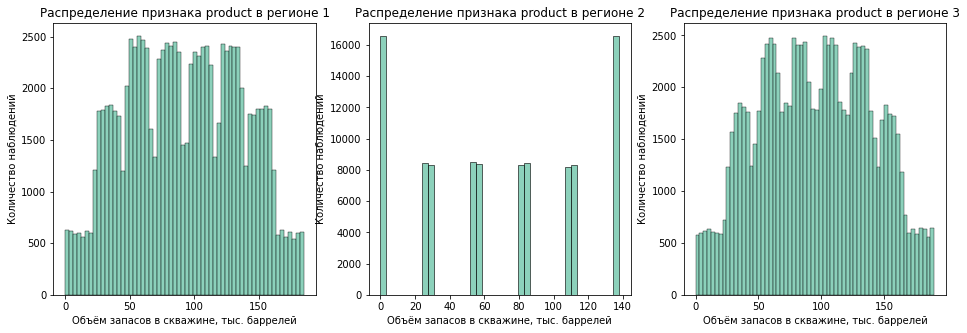

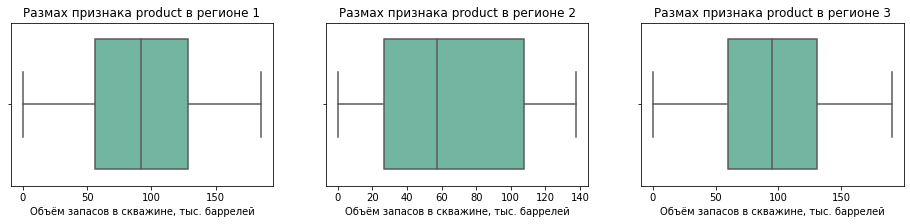

In [49]:
# на одном графике выведем распределения объема запасов нефти в скважинах по регионам
# запустим цикл по всем элементам списка dfs, для каждого набора данных - отрисуем график, i+1 - это номер региона

# построим гистограмму
fig = plt.figure(figsize=(16, 5))  # создаем фигуру и задаем параметры графика

# запускаем цикл для каждого признака    
for i, df in enumerate(dfs):  # перебираем столбцы
    ax = fig.add_subplot(1, 3, i+1)  # добавляем axes
    sns.histplot(df['product']) # рисуем гистограмму
    plt.xlabel('Объём запасов в скважине, тыс. баррелей')
    plt.ylabel('Количество наблюдений')
    plt.title(f'Распределение признака product в регионе {i+1}')
plt.show()

# построим диаграмму размаха
fig = plt.figure(figsize=(16, 3))  # создаем фигуру и задаем параметры графика

# запускаем цикл для каждого признака  
for i, df in enumerate(dfs):  # перебираем столбцы
    ax = fig.add_subplot(1, 3, i+1)  # добавляем axes
    sns.boxplot(data=df, x='product') # рисуем боксплот
    plt.xlabel('Объём запасов в скважине, тыс. баррелей')
    plt.title(f'Размах признака product в регионе {i+1}')
plt.show()

Из графиков можно сделать следующие выводы:

**Первый регион**:
* Распределение целевого признака не напоминает нормальное, оно имеет пики на определенных значениях, симметрично распределенных слева и справа от центра. Значения в интервале между 50 и 150 имеют практически равновероятный характер, но значения объема запасов нефти в скважинах за пределами этих границ — уже редко встречаются в выборке.

Это может означать, что в данном регионе есть определенные значения объема запасов, которые встречаются чаще других. Возможно, это связано с геологическими особенностями региона или другими факторами.

**Второй регион**:

* Распределение имеет шесть пиков возле таких значений: 3, 30, 55, 85, 110, 140, то есть оно больше походит на распределение признака, измеренного в целых числах.

Такое распределение может быть связано с тем, что объем запасов нефти в данном регионе зависит от определенных факторов, которые влияют на него в разной степени. Например, это могут быть геологические особенности региона, глубина залегания нефти и т.д.

**Третий регион**:

* Распределение объема запасов нефти имеет множество пиков и не носит характер нормального распределения. Само распределение симметрично относительно центра.

Это также может свидетельствовать о наличии определенных факторов, влияющих на объем запасов нефти в регионе. Однако, без дополнительной информации сложно сказать, какие именно это факторы.

Таким образом, анализ распределений целевого признака в трех регионах позволяет сделать предварительные выводы о перспективах бурения новых скважин в каждом из них.

Теперь посмотрим на диаграммы совместного рассеяния признаков в регионах.

Диаграммы рассеяния признаков в регионе 1


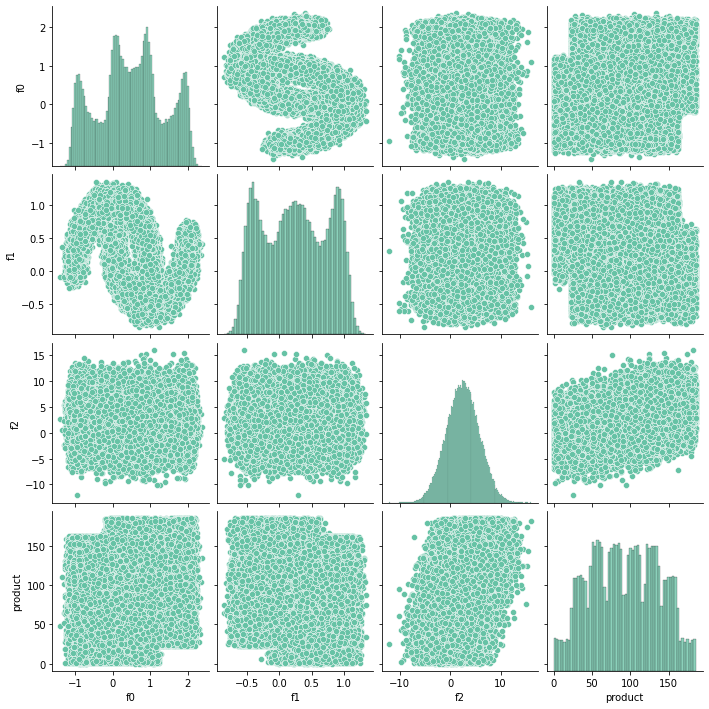

In [50]:
print(f'Диаграммы рассеяния признаков в регионе 1')
sns.pairplot(region_1)
plt.show()

На основе предоставленных данных можно сделать следующие выводы:

* Распределение признаков `f0` и `f1` не похоже на нормальное, что может указывать на сложность и неоднородность данных. Распределение `f0` симметрично относительно центра, но у него есть два пика возле среднего значения, и еще два пика возле первого и третьего квартилей, а типичное значение признака `f1` соседсвует с двумя пиками по краям. Ненормальность распределения может затруднить построение модели для предсказания объёма запасов в новых скважинах. При этом признак `f2` имеет распределение, похожее на нормальное.

* Совместное распределение признаков `product` и `f0` имеет форму прямоугольника, что говорит о наличии почти всех возможных вариантов соответствия величин. 

* Рассеяние `product` и `f1` похоже на зеркально отражённое совместное распределение `product` и `f0`. Это может быть связано с особенностями данных или спецификой процесса добычи нефти.

* Облако точек совместного распределения `product` и `f2` имеет прямое направление с положительным наклоном. Широкий интервал  парных сочетаний двух признаков может говорить о разнообразии данных и необходимости более детального анализа.

Перейдем к региону 2.

Диаграммы рассеяния признаков в регионе 2


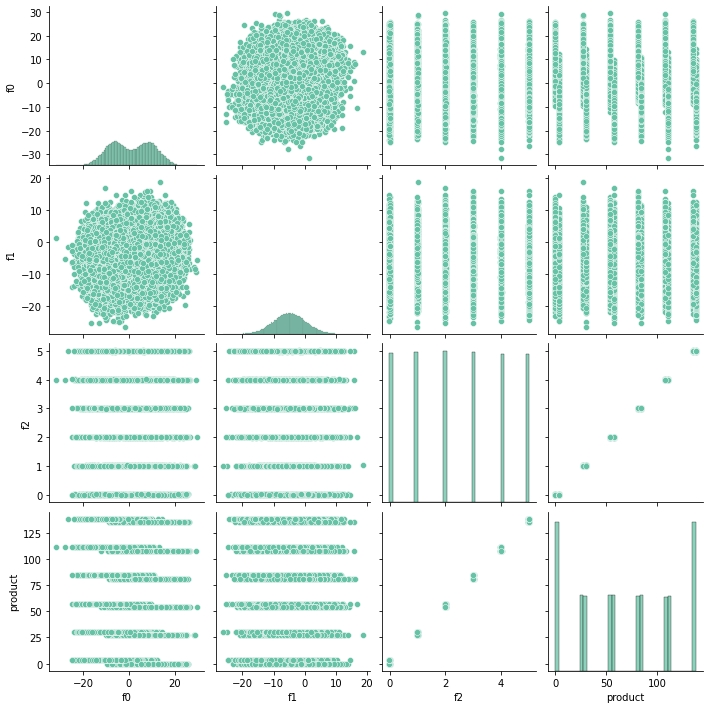

In [51]:
print('Диаграммы рассеяния признаков в регионе 2')
sns.pairplot(region_2)
plt.show()

На основе диаграмм рассеяния можно сделать следующие выводы:

* Распределение признаков `f0` и `f2` имеет несколько пиков, что может указывать на неоднородность данных. Два пика у `f0` симметричных относительно среднего значения и целых шесть пиков у `f2`. Его значения близки к 0, 1, 2 и так далее до 5. Признак `f1` имеет распределение, похожее на нормальное, но график островершинный.


* Поскольку целевой признак `product` имеет шесть пиков на шкале значений, что говорит о наличии определённых закономерностей в данных, совместные распределения целевого признака и остальных подчиняются этим закономерностям. Это видно на диаграммах рассеяния — облака точек сжимаются, поскольку `product` имеет всплески на определённых значениях, что заставляет кучно рассеиваться наблюдения около этих значений.

Завершим раздел анализом совместного распределения признаков в третьем регионе.  

Диаграммы рассеяния признаков в регионе 3


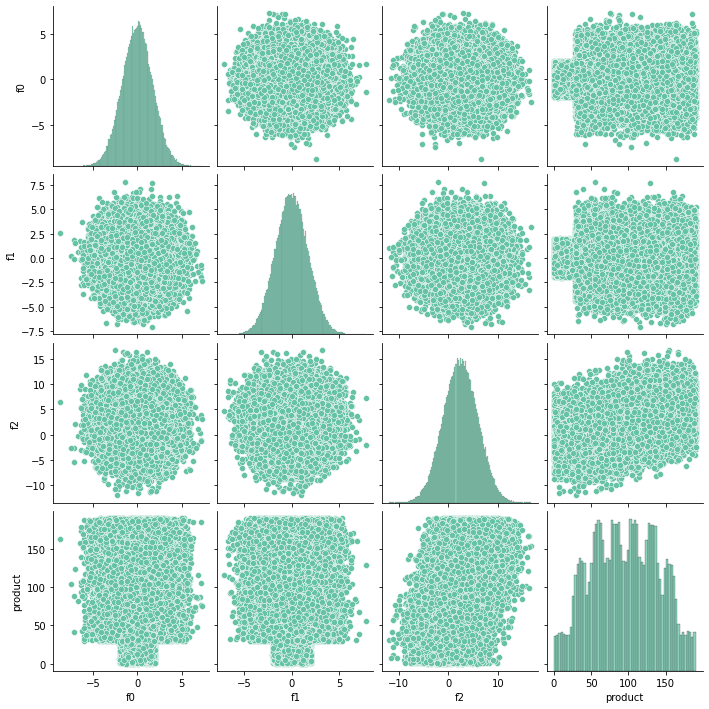

In [52]:
print('Диаграммы рассеяния признаков в регионе 3')
sns.pairplot(region_3)
plt.show()

Итак, по представленным графикам можно заключить следующее:

* Признаки f0, f1 и f2 имеют нормальное островершинное распределение, что может упростить работу с данными и повысить точность модели.
* Поскольку целевой признак не распределен нормально, совместные распределения `product` и остальных признаков в третьем регионе похожи на соответствующие распределения в первом регионе. Этот вывод может помочь при построении модели и анализе данных.

Далее проведем корреляционный анализ признаков.

### Корреляционный анализ признаков

Проанализировав совместное распределение признаков с помощью диаграмм рассеяния, проведём корреляционный анализ для того, чтобы дать количественную оценку тесноте взаимосвязи между целевым признаком и объясняющими признаками.

Поскольку признаки являются количественными, а их распределение не соответствует нормальному, для анализа взаимосвязей целесообразно использовать **коэффициенты корреляции Спирмена**.

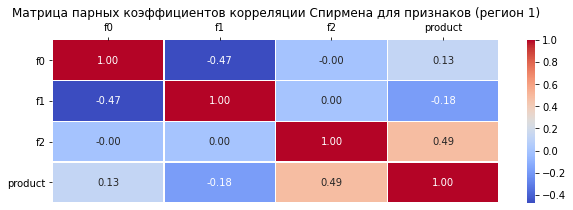

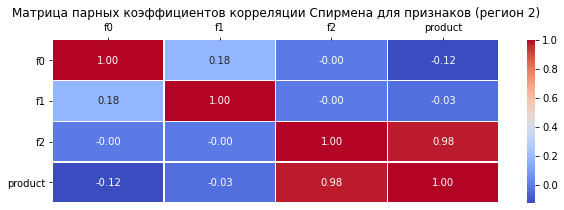

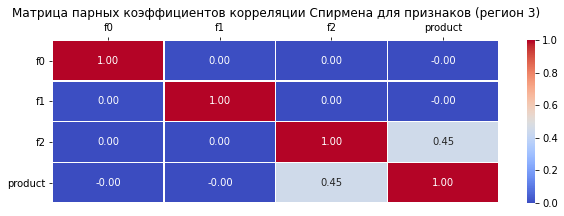

In [53]:
# запустим цикл по всем элементам списка dfs, для каждого набора данных - построим матрицу корреляций, i+1 - это номер региона
for i, df in enumerate(dfs):
    # запишем таблицу с матрицей корреляции в отдельную переменную
    df_corr = df.corr(method = 'spearman')

    # изобразим таблицу в виде хитмэпа
    plt.figure(figsize=(10,3))
    ax = sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
    ax.xaxis.tick_top()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=360, ha='right')
    plt.title(f'Матрица парных коэффициентов корреляции Спирмена для признаков (регион {i+1})')
    plt.show()
    print('\n')

Из представленных матриц корреляции можно сделать следующие выводы:

**Регион 1.**
В регионе 1 признаки `f0` и `f1` имеют очень слабую отрицательную корреляцию с признаком `product`, но признак `f2` имеет среднюю положительную корреляцию с объемом запасов в скважине. Это означает, что увеличение значения `f2` приводит к увеличению значения `product`, и наоборот.

**Регион 2.**
В регионе 2 признак `f2` сильно коррелирует с `product` (коэффициент корреляции равен 0,98), что говорит о том, что эти признаки тесно связаны друг с другом. Признаки `f0` и `f1` также имеют некоторую корреляцию с объемом запасов, но она очень слабая.

**Регион 3.**
В регионе 3 все признаки не имеют значимой корреляции друг с другом и с признаком `product`. Это может означать, что в этом регионе нет явной корреляционной взаимосвязи между признаками и объемом запасов в скважине.

Мы загрузили данные, изучили проблемы в датасетах и завершили исследовательский анализ данных.

Результаты исследовательского анализа признаков в трёх регионах позволяет сделать следующие выводы:

**Описательные статистики**:

*Объём запасов.* В среднем наибольший объём запасов нефти наблюдается в регионе 3, а наименьший — в регионе 2. При этом разброс значений объёма запасов во всех регионах достаточно большой. Это говорит о том, что скважины в каждом из регионов могут иметь как очень большие, так и очень маленькие объёмы запасов.

*Признаки f0, f1 и f2.* Значения признаков f0, f1 и f2 варьируются в широком диапазоне во всех трёх регионах. Средние значения и медианы этих признаков различаются между регионами. Это может указывать на то, что эти признаки имеют разные распределения в разных регионах.

**Распределение целевого признака**:
* В первом и третьем регионах распределение целевого признака (объём запасов в скважине) не является нормальным. Оно имеет пики на определённых значениях, симметрично распределённых слева и справа от центра распределения. Это может указывать на то, что в этих регионах есть определённые значения объёма запасов нефти в скважинах, которые встречаются чаще остальных.

* Во втором регионе распределение целевого признака имеет шесть пиков возле определённых значений. Это может говорить о том, что объём запасов нефти в этом регионе более равномерно распределён по определённым значениям.

**Совместное распределение признаков**:
1. Признаки `f0`, `f1` и `f2` имеют разные распределения в каждом регионе: где-то они похожи на нормальное распределение, где-то имеют несколько пиков или несимметричны относительно центра.
2. Целевой признак `product` имеет множество пиков и не носит характер нормального распределения во всех регионах. Это усложняет анализ данных и построение модели для предсказания объёма запасов в новых скважинах.
3. Совместные распределения целевого признака и остальных признаков в разных регионах отличаются по причине разных закономерностей распределения самих признаков. Однако для более точного результата необходимо провести более глубокий анализ данных и построить модель, которая будет учитывать все особенности и взаимосвязи между признаками.

**Корреляционная взаимосвязь признаков**:

Признаки `f0`, `f1` и `f2` по-разному влияют на признак `product` в зависимости от региона.
* В регионе 1 признаки `f0` и `f1` имеют очень слабую отрицательную корреляцию с признаком `product`, а признак `f2` имеет среднюю положительную корреляцию. 
* В регионе 2 признак `f2` сильно коррелирует с `product` (коэффициент корреляции равен 0,98), что говорит о том, что эти признаки линейно взаимосвязаны друг с другом. 
* В регионе 3 все признаки не имеют значимой корреляции друг с другом и с признаком `product`, кроме `f2`.

Теперь можно переходить к следующему этапу проекта.

## Обучение и проверка модели

В данном разделе проекта мы будем обучать и проверять модель для каждого региона. Это позволит нам оценить точность модели и её способность предсказывать запасы сырья.

Для этого мы выполним следующие шаги:
1. Разделим данные на обучающую и валидационную выборки в соотношении 75:25.
2. Обучим модель на обучающей выборке и сделаем предсказания на валидационной.
3. Сохраним предсказания и правильные ответы на валидационной выборке для последующего анализа.
4. Рассчитаем средний запас предсказанного сырья и среднеквадратическую ошибку (RMSE) модели.
5. Проанализируем результаты и оценим точность модели.


В качестве модели для обучения выбрана **модель линейной регрессии** потому, что согласно условию задачи: *остальные модели недостаточно предсказуемы для решения поставленной задачи*.

Чтобы упростить построение модели и проанализировать результаты её обучения по каждому региону, напишем функцию, которая:
- Делит данные на обучающую и валидационную выборки в соотношении 75:25.
- Обучает модель линейной регрессии и делает предсказания по ней.
- Сохраняет в отдельный датафрейм предсказания и правильные ответы на валидационной выборке для последующего анализа.
- Рассчитывет средний запас сырья по прогнозу и RMSE моделей.

In [54]:
# напишем функцию для обучения модели
def regression_model(df, num):
    X = df.drop(['product'], axis=1) # сохраняем признаки
    y = df['product'] # и отдельно - целевую переменную
    # разбиваем данные на обучающую и валидационную выборки в нужном соотношении
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE) 
    
    # масштабируем признаки для двух выборок
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # инициируем и обучаем модель
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # строим прогноз по валидационной выборке
    y_pred = model.predict(X_val_scaled)
    
    # рассчитываем RMSE по модели
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    # сохраняем в отдельном датафрейме предсказания и правильные ответы
    model_results = pd.DataFrame({
    'y_pred': y_pred,
    'y_true': y_val
    })
    
    # возращаем датафрейм с результатами прогнозирования и истинными значениями, а также RMSE
    return model_results, rmse

Теперь можно обучить модель для каждого региона. Сделаем это при помощи цикла и сохраним результаты в отдельную переменную. 

In [55]:
# создаем список 
results_comparison = []

# запускаем цикл по датафреймам и номерам регионов
for n, df in zip([1,2,3], dfs):
    # применим ранее составленную функцию на датафреймы
    model_results, rmse  = regression_model(df, n)
    # запишем строку с результатами для текущего региона
    results_comparison.append({'region': n, 
             'average_forecast_production': model_results['y_pred'].mean(), 
             'rmse': rmse})
    # сохраним таблицу с результатами обучения модели (предсказания и правильные ответы)
    # в глобальный список переменных для дальнейшей работы
    globals()['model_results_%s' % n] = model_results
# преобразуем список в датафрейм    
results_comparison = pd.DataFrame(results_comparison)    

Итак, мы обучили три модели для трех регионов. Посмотрим на итоговые результаты.

In [56]:
# выведем на экран итоговые результаты обучения моделей (средний запас сырья по прогнозу и RMSE моделей)
results_comparison.round(2)

,region,average_forecast_production,rmse
0,1,92.40,37.76
1,2,68.71,0.89
2,3,94.77,40.15


Из таблицы видно, что для каждого региона модель предсказывает средний запас сырья в новой скважине. Также можно заметить, что среднеквадратическая ошибка (RMSE) для модели варьируется в зависимости от региона.

В первом регионе модель предсказывает средний объём запасов в 92,4 тыс. баррелей с RMSE 37,76. Это означает, что предсказания модели могут отклоняться от реальных значений на величину около 38 тыс. баррелей.

Во втором регионе модель предсказывает средний объём запасов в 68,71 тыс. баррелей с очень низкой RMSE — 0,89. Это говорит о том, что модель хорошо предсказывает объём запасов во втором регионе.

В третьем регионе модель предсказывает средний объём запасов в 94,77 тыс. баррелей с относительно высокой RMSE — 40,15. Это может указывать на то, что в данных третьего региона есть факторы, которые модель не учитывает или учитывает недостаточно точно.

**Выводы:**
* Модель достаточно точно предсказывает объём запасов для второго региона.
* Для первого и третьего регионов модель также даёт неплохие результаты, но с большей ошибкой.

Теперь можно перейти к следующему этапу исследования.

## Подготовка к расчёту прибыли

На этапе подготовки к расчёту прибыли мы должны:
-  Сохранить ключевые значения для расчётов в отдельных переменных.
- Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. 
- Сравнить безубыточный объём сырья со средним запасом нефти к скважине в каждом регионе.

Сохраним ключевые значения для расчётов в отдельных переменных.

Будем учитывать следующие условия задания:
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

Получается следующее:
- Чтобы разработка была безубыточной, доход от добычи нефти из 200 самых емких скважин должен быть больше или равен 10 млрд рублей.
- Доход от одной скважины составляет 450 рублей умноженный на объем запасов в скважине (в тыс. баррелей).

**Уравнение для точки безубыточности**:

    Бюджет разработки (Себестоимость) = Доход от 200 лучших скважин
    Бюджет разработки = Число лучших скважин * Доход от продажи одного барреля нефти * Объем запасов нефти для безубыточной разработки в одной скважине

*Тогда*:

    Объем запасов нефти для безубыточной разработки в одной скважине = Бюджет разработки / (Число лучших скважин * Доход от продажи одного барреля нефти)

*Или*: $V = \frac{B}{n * P}$, *где*

    V — объём запасов для безубыточной разработки в одной скважине (тыс. баррелей),
    B — бюджет разработки (тыс. рублей),
    n — число лучших скважин,
    P — доход от продажи одного барреля нефти (рублей).
    
Приступим к расчету.

In [57]:
# сохраним в отдельные переменные ключевые значения
N_WELLS = 200 # число лучших скважин
DEVELOPMENT_BUDGET = 10000000 # бюджет разработки (В ТЫС. РУБЛЕЙ!)
INCOME_PER_BARREL = 450 # доход от продажи одного барреля нефти (рублей)

# найдем объём запасов для безубыточной разработки в одной скважине (тыс. баррелей)
EQUILIBRIUM_PRODUCT = DEVELOPMENT_BUDGET / (N_WELLS * INCOME_PER_BARREL)

In [58]:
# выведем на экран полученное значение
print(f"Объем запасов нефти в одной скважине для безубыточной разработки в регионе составил: {round(EQUILIBRIUM_PRODUCT, 2)}")

Объем запасов нефти в одной скважине для безубыточной разработки в регионе составил: 111.11


In [59]:
for i in range(len(results_comparison)):
    if results_comparison['average_forecast_production'][i] < EQUILIBRIUM_PRODUCT:
        print(f"Прогноз среднего объема добычи в одной скважине региона {results_comparison['region'][i]} ниже безубыточного объема добычи")
    else:
        print(f"Прогноз среднего объема добычи в одной скважине региона {results_comparison['region'][i]} равен безубыточному объему добычи или больше него")

Прогноз среднего объема добычи в одной скважине региона 1 ниже безубыточного объема добычи
Прогноз среднего объема добычи в одной скважине региона 2 ниже безубыточного объема добычи
Прогноз среднего объема добычи в одной скважине региона 3 ниже безубыточного объема добычи


Далее произведем расчет прибыли и рисков.

## Расчёт прибыли и рисков 

В данном разделе мы сосредоточимся на расчёте дохода по выбранным скважинам с использованием предсказаний модели. 

Для этого необходимо написать функцию, которая выполняет следующие шаги:

- Выбирает скважины с максимальными значениями предсказаний;
- Суммирует целевое значение объёма сырья на реальных значениях;
- Рассчитывает фактический доход для полученного объёма сырья.

In [60]:
# определим функцию расчета дохода от скважин в регионе
# в ней аргументами будут:
# реальные значения (true_values)
# прогнозные значения (predicted_values)
# и число лучших скважин (n_wells)
def income_calculation(true_values, predicted_values, n_wells):
    # сортируем предсказанные объемы добычи в скважинах по убыванию 
    # сохраняем индексы этих значений
    pred_index_sort = predicted_values.sort_values(ascending=False).index
    # отбираем реальные значения по индексу отсортированных предсказанных значений и оставляем первые n_wells
    selected = true_values[pred_index_sort][:n_wells]
    # функция вернет доход от продажи нефти с лучших скважин в ТЫС. РУБЛЕЙ 
    return INCOME_PER_BARREL * selected.sum()

Написав функцию расчета дохода продажи нефти от 200 лучших скважин, перейдем к расчету рисков и прибыли для каждого региона.

По заданию нам необходимо:
- Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- Предложить регион для разработки скважин и обосновать выбор.


При расчете прибыли и рисков для каждого региона будем исходить из условия: *При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.*

То есть будем тысячекратно делать выборку по 500 скважин, и из них отбирать 200 лучших скважин для разработки, по которым будем рассчитывать прибыль.

In [61]:
# создаем два списка: 
# bootstrap_results - список, в котором будут указаны средняя прибыль, 95%-й доверительный интервал и риск убытков для каждого региона
# bootstrap_values - список полученных после расчета техникой Bootstrap из 1000 выборок значений прибыли по каждому региону
bootstrap_results = []
bootstrap_values = []

# запускаем цикл предсказаний модели по каждому региону 
for n, model_results in zip([1,2,3], [model_results_1, model_results_2, model_results_3]):
    # установим значение RandomState для бутстрепа
    state = np.random.RandomState(12345)
    # число взятий выборок - 1000 
    bootstrap_samples = 1000
    # формируем список для записи значений прибыли
    values = []
    # запускаем цикл взятия выборок
    for i in range(bootstrap_samples):
        # формируем выборки по 500 скважин с возвращением и записываем выборку в отдельную переменную 
        model_results_sample = (model_results).sample(n=500, random_state=state, replace=True)
        # далее рассчитываем доход от 200 лучших скважин из выборки по 500 
        # этим действием получаем расчет прибыли (Прибыль = Выручка - Себестоимость) в МЛН РУБЛЕЙ(!)
        values.append((income_calculation(true_values = model_results_sample['y_true'],
                                          predicted_values = model_results_sample['y_pred'],
                                          n_wells = N_WELLS) - DEVELOPMENT_BUDGET)/1000) # вычитаем бюджет на разработку в регионе и делим на 1000
    # сохраняем список values как Series
    values = pd.Series(values)
    # сохраняем список bootstrap_values как датафрейм
    bootstrap_values = pd.DataFrame(bootstrap_values)
    # в столбец для определенного региона датафрейма bootstrap_values передаем соответствующие значения прибыли
    bootstrap_values[f"values_{n}"] = values
    
    # записываем в отдельные переменные среднее значение прибыли, нижнюю и верхнюю границы 95%-го доверительного интервала
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.925)
    
    # p-value будет соответствовать доле значений в values, которые лежат до нижней границы 95%-го доверительного интервала
    pvalue = (values < 0).mean()
    
    # формируем итоговые результаты расчета прибыли
    bootstrap_results.append({'region': n,
                              'average_profit': round(mean, 2),
                              'lower_conf_int': round(lower, 2),
                              'upper_conf_int': round(upper, 2),
                              'pvalue': round(pvalue, 3)})
# сохраняем список bootstrap_results как датафрейм 
bootstrap_results = pd.DataFrame(bootstrap_results)

Мы выполнили все необходимые действия. Теперь посмотрим какие у нас получились распределения прибыли в регионах.

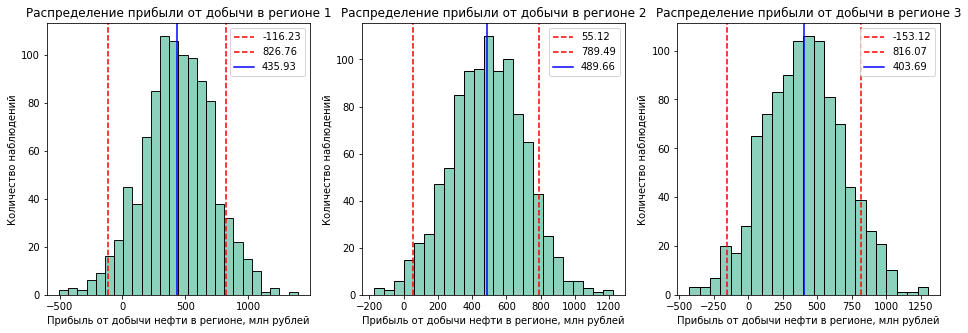

In [62]:
# построим гистограмму распределения прибыли
fig = plt.figure(figsize=(16, 5))  # создаем фигуру и задаем параметры графика

# запускаем цикл для каждого столбца (каждого региона)  
for i, column in enumerate(bootstrap_values.columns):  # перебираем столбцы
    ax = fig.add_subplot(1, 3, i+1)  # добавляем axes
    sns.histplot(data=bootstrap_values, x=column) # рисуем гистограмму
    # также на графике отложим среднее значение прибыли и границы доверительного интервала
    plt.axvline(x=bootstrap_results.loc[i,'lower_conf_int'], color='r', linestyle='--', label=str(bootstrap_results.loc[i,'lower_conf_int']))
    plt.axvline(x=bootstrap_results.loc[i,'upper_conf_int'], color='r', linestyle='--', label=str(bootstrap_results.loc[i,'upper_conf_int']))
    plt.axvline(x=bootstrap_results.loc[i,'average_profit'], color='b', linestyle='-', label=str(bootstrap_results.loc[i,'average_profit']))
    plt.xlabel('Прибыль от добычи нефти в регионе, млн рублей') # подписываем ось X
    plt.ylabel('Количество наблюдений') # подписываем ось Y
    plt.title(f'Распределение прибыли от добычи в регионе {i+1}') # пишем заголовок
    plt.legend() # добавим легенду
plt.show() # показываем полученный график

Красными пунктирными линиями обозначен 95%-ый доверительный интервал, синей сплошной линей - среднее значение. 

Распределения прибыли во всех трёх регионах имеют тенденцию к нормальному распределению. Это позволяет нам с высокой степенью уверенности (95 %) определить интервал, в который попадёт среднее значение прибыли при разработке нефтяных скважин в каждом из этих регионов. Кроме того, мы можем наглядно оценить уровень ожидаемой прибыли от запуска нефтедобычи.

Чтобы было удобнее сравнивать регионы по потенциальной прибыли - изобразим эти распределения на одном графике.

In [63]:
# преобразование датафрейма в длинный формат
melted_bootstrap_values = bootstrap_values.melt(var_name='region', value_name='values').replace({'region': {'values_':'Регион '}}, regex=True)

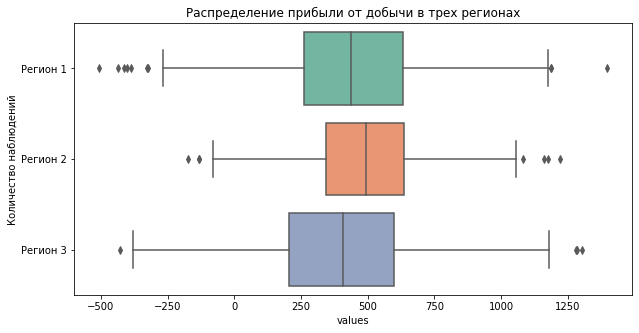

In [64]:
# построим распределения по трем регионам на одном графике
plt.figure(figsize=(10, 5))
sns.boxplot(x=melted_bootstrap_values['values'], y=melted_bootstrap_values['region'])
plt.ylabel('Количество наблюдений') # подписываем ось Y
plt.title(f'Распределение прибыли от добычи в трех регионах') # пишем заголовок
plt.show() # показываем график

На графиках выше представлены распределения прибыли от нефтедобычи в трёх регионах.

* В Регионе 1 распределение прибыли имеет острый пик, при этом её типичное значение ниже, чем во втором регионе. Оно представляет собой нечто среднее между вторым и третьим регионом. Интервал размаха меньше, чем в третьем регионе, но медиана меньше, чем во втором.

* Распределение прибыли в Регионе 2 сосредоточено в более узком интервале, а его медиана больше, чем в первом и третьем регионах. Значения могут уходить в область отрицательных величин, но не так далеко, как у первого и третьего региона.

* Регион 3 отличается наиболее широким распределением, и его левый хвост уходит в область меньше нуля, что указывает на вероятность убытков, как и в первом регионе.

Подробнее проанализируем среднее значение прибыли, доверительный интервал и риск убытков в каждом регионе.

In [65]:
# выведем на экран результаты бутстрепа для каждого региона
bootstrap_results

,region,average_profit,lower_conf_int,upper_conf_int,pvalue
0,1,435.93,-116.23,826.76,0.061
1,2,489.66,55.12,789.49,0.011
2,3,403.69,-153.12,816.07,0.071


На основе полученных данных можно сделать следующие выводы:

* В первом регионе средняя прибыль составляет 435,93 млн рублей, нижняя граница 95%-го доверительного интервала указывает на убыток в размере 116,23 млн рублей, верхняя граница — 826,76 млрд рублей. Риск убытков составляет 0,061. Это означает, что вероятность получения отрицательной прибыли в этом регионе составляет 6,1 %, что превышает пороговое значение в 2,5 %.

* Во втором регионе средняя прибыль — 489,66 млн рублей, нижняя граница — 55,12 млн рублей, верхняя — 789,49 млрд рублей. Риск убытков — 1,1 %, что меньше 2,5 %, поэтому этот регион подходит для разработки скважин.

* В третьем регионе средняя прибыль — 403,69 млн рублей, нижняя граница — убыток в размере 153,12 млн рублей, верхняя — 816,07 млрд рублей. Риск убытков равен 0,071. Это значит, что в этом регионе вероятность получить отрицательную прибыль составляет 7,1 %, и он не является привлекательным для бурения новых скважин.

Если исходить из условия задания: *После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.*, то по этим критериям **второй регион** следует признать лучшим для дальнейшей нефтеразработки.

Этот выбор обусловлен тем, что:
* Риск убытков во втором регионе составляет всего 1,1 %, что меньше заданного ограничения в 2,5 %. Это означает, что вероятность получения отрицательной прибыли невелика. В то время как в двух других регионах риски выше предельного значения;
* Средняя прибыль во втором регионе самая высокая среди всех рассмотренных вариантов.

При выборе региона для разработки новых скважин важно учесть не только ожидаемую прибыль и риск убытков, но и качество модели для прогнозирования объёма запасов нефти.

По сравнению с моделями для первого и третьего регионов, во втором регионе модель предсказывает запасы с очень низкой среднеквадратической ошибкой (RMSE = 0,89). Это говорит о том, что выбранная модель линейной регрессии хорошо предсказывает объём запасов. Однако во втором регионе модель предсказывает средний объём запасов в 68,71 тыс. баррелей, что является самой низкой средней величиной ожидаемых запасов для добычи. 

Также стоит отметить, что в регионе 2 признак `f2` сильно коррелирует с `product` (коэффициент корреляции равен 0,98), что указывает на их линейную взаимосвязь. Поэтому необходимы дополнительные исследования относительно значимости признаков и целесообразности их использования в таком анализе, не говоря уже о выборе типа модели для прогнозирования запасов.